In [12]:
import numpy as np
import scipy.integrate as spi

import spacepy.time as spt
import spacepy.coordinates as spc
import spacepy.irbempy as ib

import matplotlib.pyplot as plt

In [13]:
# INTITIAL CONDITIONS
# we use the GEO coordinates: Earth-centered, and Earth-fixed
# Format: (X, Y, Z), where (0, 0, 0) is the center of the Earth
# We use meters for units
X_0 = [6.6e6, 0, 0]
# similarly for velocities
# we use m/s for units
V_0 = [-100000, 100000, 100]

"""# Coordinate system: (lat, lon, alt) = (47.6205, -122.3493, 20000)
# Velocity system: (v_north, v_east, v_down) = (0, 0, 10)
X_0 = [3, 0, 0]
SPEED_OF_LIGHT = 299792458 # m/s
# X_0 = [47.6205, -122.3493, 20000]
V_0 = [0, 0, 10]
"""

SPEED_OF_LIGHT = 3e8 # m/s
EARTH_RADIUS = 6.371e6
CHARGE = 15 # coulomb cancel out
M = 2
T = spt.Ticktock('2022-02-02T12:00:00', 'ISO')

In [14]:
# EQUATIONS OF MOTION
# neglect gravity - only the lorentz force from the geomagnetic field is considered
def rel_lambda(v: np.ndarray) -> float:
    return 1 / np.sqrt(1 - (np.linalg.norm(v) / SPEED_OF_LIGHT)**2)


def force(x: np.ndarray, v: np.ndarray) -> np.ndarray:
    coords = spc.Coords(x, 'GEO', 'car')
    field = ib.get_Bfield(T, coords)["Bvec"]
    # B = np.array([result.bx, result.by, result.bz])
    F = rel_lambda(v) * CHARGE * np.cross(v, field)
    return F.flatten()


# linearized equations of motion
def y_prime(y, t):
    x = y[:3]
    v = y[3:]
    a = force(x, v) / M
    return np.concatenate((v, a))

In [15]:
# setup of initial conditions
TIMESTEP = 2
N_STEPS = 300
t = np.linspace(0, TIMESTEP*N_STEPS, N_STEPS)
Y = np.zeros((N_STEPS, 6))
Y[0] = np.concatenate((X_0, V_0))


In [ ]:
# integrate the equations of motion
Y = spi.odeint(y_prime, Y[0], t)


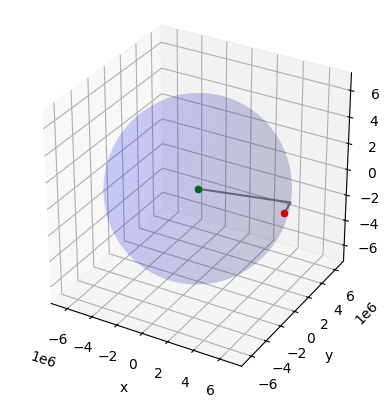

In [ ]:
# plot the trajectory on a three-dimensional plot
plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ensure the aspect ratio is correct
ax.set_box_aspect([1,1,1])



# starting point
ax.scatter3D(Y[0, 0], Y[0, 1], Y[0, 2], c='r')
# trajectory
ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'gray')
# ending point
ax.scatter3D(Y[-1, 0], Y[-1, 1], Y[-1, 2], c='g')

# Also plot the Earth
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = EARTH_RADIUS * np.outer(np.cos(u), np.sin(v))
y = EARTH_RADIUS * np.outer(np.sin(u), np.sin(v))
z = EARTH_RADIUS * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.1)
plt.show()